# Разработка персонализированных предложений для постоянных клиентов интернет-магазина «В один клик»

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов.
Задача - разработать персонализированные предложения для постоянных покупателей.\
Для выполнения задачи необходимо:
- построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца;
- включить в исследование дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца;
- выделить сегменты покупателей и разработать для них персонализированные предложения, используя данные модели и данные о прибыльности клиентов.

Описание данных:\
Данные для работы находятся в нескольких таблицах:

**market_file.csv** - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- id — номер покупателя в корпоративной базе данных;
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень»;
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт»;
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель;
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента;
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце;
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте;
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев;
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев;
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца;
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца;
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта;
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

**market_money.csv** - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных;
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц';
- Выручка — сумма выручки за период.

**market_time.csv** - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных;
- Период — название периода, во время которого зафиксировано общее время;
- минут — значение времени, проведённого на сайте, в минутах.

**money.csv** - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных;
- Прибыль — значение прибыли.

In [1]:
!pip install phik
!pip install shap 
!pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
import phik
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import shap

## Загрузка данных

In [3]:
#считывание csv-файлов и сохранение в датафреймы
market_file = pd.read_csv('/datasets/market_file.csv', sep=',')
market_money = pd.read_csv('/datasets/market_money.csv', sep=',')
market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [4]:
# получение первых 10 строк датафрейма market_file
market_file.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


In [5]:
# вывод основной информации о датафрейме market_file
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
# получение первых 10 строк датафрейма market_money
market_money.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [7]:
# вывод основной информации о датафрейме market_money
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
# получение первых 10 строк датафрейма market_time
market_time.head(10)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


In [9]:
# вывод основной информации о датафрейме market_time
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
# получение первых 10 строк датафрейма money
money.head(10)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


In [11]:
# вывод основной информации о датафрейме money
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Вывод по результатам загрузки данных:**\
На этапе загрузки данных были изучены датафреймы market_file, market_money, market_time, money а также основная информация о данных датафреймах.

## Предобработка данных

In [12]:
# приведение всех столбцов датафреймов market_file, market_money, market_time, money к нижнему регистру
market_file.columns = market_file.columns.str.lower()
market_money.columns = market_money.columns.str.lower()
market_time.columns = market_time.columns.str.lower()
money.columns = money.columns.str.lower()

In [13]:
# переименование столбцов датафрейма market_file
market_file = market_file.rename(columns={'покупательская активность':'покупательская_активность', 
                            'тип сервиса':'тип_сервиса', 
                            'разрешить сообщать':'разрешить_сообщать'
                                         })

In [14]:
# определение уникальных значений столбца тип_сервиса
market_file['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [15]:
# замена значений в столбце тип_сервиса
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт','стандарт')

In [16]:
# определение уникальных значений столбца период
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [17]:
# замена значений в столбце период
market_time['период'] = market_time['период'].replace('предыдцщий_месяц','предыдущий_месяц')

In [18]:
# определение количества дубликатов в датафрейме market_file
market_file.duplicated().sum()

0

In [19]:
# определение количества дубликатов в датафрейме market_money
market_money.duplicated().sum()

0

In [20]:
# определение количества дубликатов в датафрейме market_time
market_time.duplicated().sum()

0

In [21]:
# определение количества дубликатов в датафрейме money
money.duplicated().sum()

0

**Вывод по итогам предобработки данных:**\
На этапе предобработки данных столбцы всех данных датафреймов были приведены к нижнему регистру и переименованы для корректной работы в дальнейшем. Также было выявлено, что все датафремы не содержат пропусков и дубликатов. В процессе предобработки данных были изучены неявные дубликаты и приведены к правильному виду для выполнения следующих этапов работы с проектом.

## Исследовательский анализ данных

Text(0.5, 1.0, 'Покупательская активность')

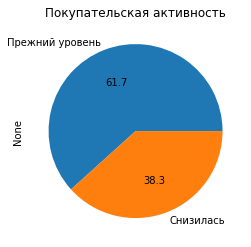

In [22]:
# построение круговой диаграммы
market_file.groupby('покупательская_активность').size().plot(kind='pie', autopct='%.1f')
plt.title('Покупательская активность')

По данной столбчатой диаграмме можно сказать, что покупательская активность на прежнем уровне у 2/3 покутелей.

Text(0.5, 1.0, 'Тип сервиса')

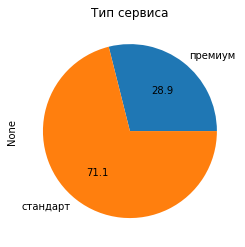

In [23]:
# построение круговой диаграммы
market_file.groupby('тип_сервиса').size().plot(kind='pie', autopct='%.1f')
plt.title('Тип сервиса')

Исходя из полученного графика, можно сделать вывод о том, что тип сервиса более 70% покупателей - стандарт.

Text(0.5, 1.0, 'Разрешить сообщать')

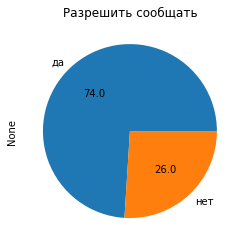

In [24]:
# построение круговой диаграммы
market_file.groupby('разрешить_сообщать').size().plot(kind='pie', autopct='%.1f')
plt.title('Разрешить сообщать')

Данная круговая диаграмма показывает, что 74% покупателей согласны на дополнительные предложения о товарах.

Text(0.5, 1.0, 'Популярная категория')

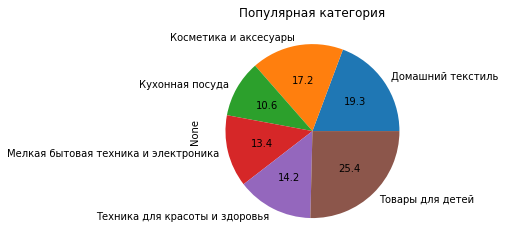

In [25]:
# построение круговой диаграммы
market_file.groupby('популярная_категория').size().plot(kind='pie', autopct='%.1f')
plt.title('Популярная категория')

По данной круговой диаграмме можно сказать, что самой популярной категорией являются товары для детей (25,4%), наименее популярной - кухонная посуда (10,6%) 

<AxesSubplot:>

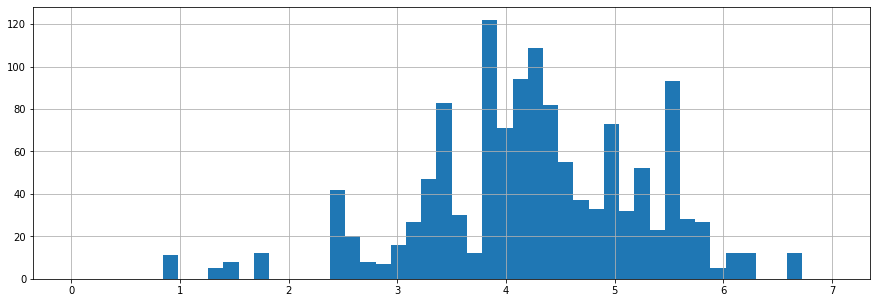

In [26]:
#построение гистаграммы по столбцу маркет_актив_6_мес
market_file['маркет_актив_6_мес'].hist(bins=50, range = (0, 7), figsize=(15, 5))

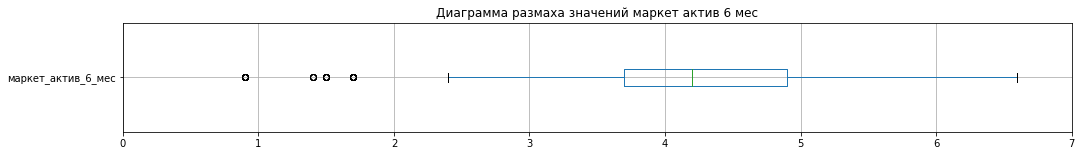

In [27]:
# построение диаграммы размаха по столбцу маркет_актив_6_мес
fig, ax = plt.subplots(figsize = (17,2))
ax = market_file[['маркет_актив_6_мес']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений маркет актив 6 мес')
ax.set_xlim(0, 7);

In [28]:
# вывод числового описания данных 
market_file['маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

По данным графиков можно сказать, что значения столбца маркет_актив_6_мес имеют выбросы, а среднее значение и медиана близки по значению. Также по гистограмме видно, что столбец маркет_актив_6_мес не имеет нормального распределения

<AxesSubplot:>

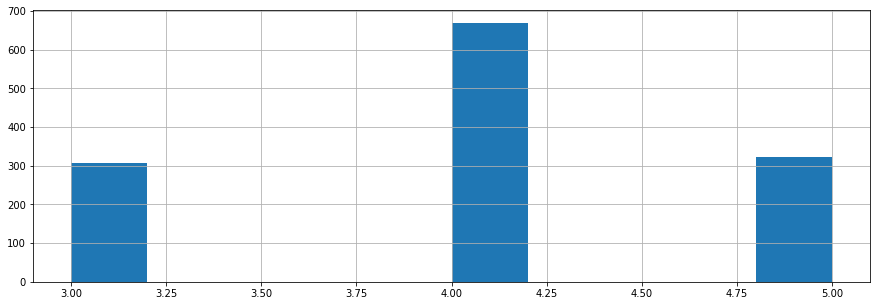

In [29]:
#построение гистаграммы по столбцу маркет_актив_тек_мес
market_file['маркет_актив_тек_мес'].hist(bins=10, range = (3, 5), figsize=(15, 5))

In [30]:
# вывод числового описания данных 
market_file['маркет_актив_тек_мес'].describe()

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64

По данным числового описания и гистограммы можно сделать вывод о том, что наиболее часто встречается значение равное 4. Оно всречается почти у 50% покупателей.

<AxesSubplot:>

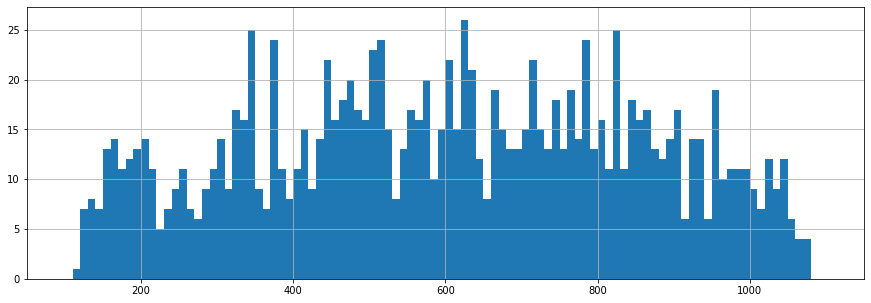

In [31]:
#построение гистаграммы по столбцу длительность
market_file['длительность'].hist(bins=100, range = (100, 1100), figsize=(15, 5))

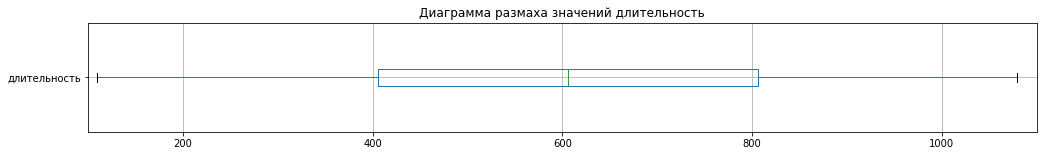

In [32]:
# построение диаграммы размаха по столбцу длительность
fig, ax = plt.subplots(figsize = (17,2))
ax = market_file[['длительность']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений длительность')
ax.set_xlim(100, 1100);

In [33]:
# вывод числового описания данных 
market_file['длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

По данным графиков можно сказать, что значения столбца длительность выбросов не имеет, а среднее значение и медиана близки по значению. По гистограмме видно, что столбец длительность не имеет нормального распределения.

<AxesSubplot:>

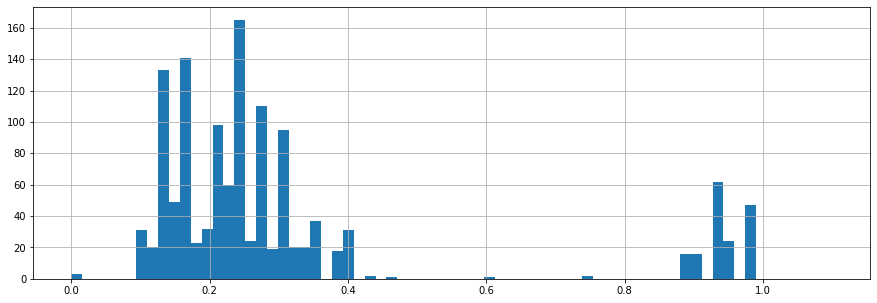

In [34]:
#построение гистаграммы по столбцу акционные_покупки
market_file['акционные_покупки'].hist(bins=70, range = (0, 1.1), figsize=(15, 5))

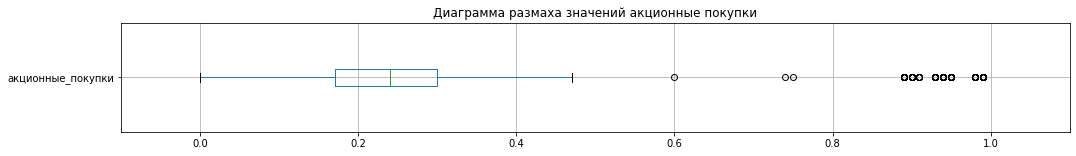

In [35]:
# построение диаграммы размаха по столбцу акционные_покупки
fig, ax = plt.subplots(figsize = (17,2))
ax = market_file[['акционные_покупки']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений акционные покупки')
ax.set_xlim(-0.1, 1.1);

In [36]:
# вывод числового описания данных 
market_file['акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

По данным графиков можно сказать, что значения столбца акционные_покупки имеет выбросы, среднее значение и медиана отличаются по значению. По гистограмме видно, что столбец акционные_покупки не имеет нормального распределения. Также можно заметить, что в столбце акционные_покупки есть значения 0, следовательно покупатель либо не покупал акционные товары, либо не совершал покупки в принципе.

<AxesSubplot:>

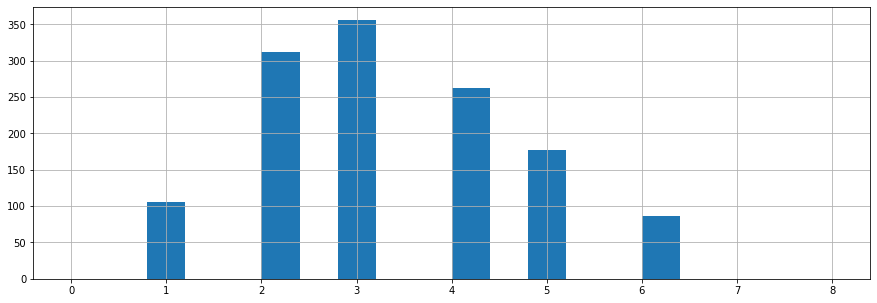

In [37]:
#построение гистаграммы по столбцу средний_просмотр_категорий_за_визит
market_file['средний_просмотр_категорий_за_визит'].hist(bins=20, range = (0, 8), figsize=(15, 5))

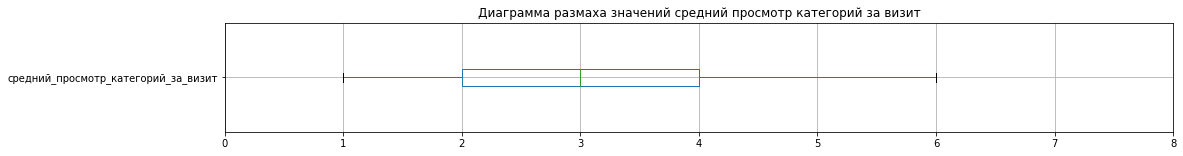

In [38]:
# построение диаграммы размаха по столбцу средний_просмотр_категорий_за_визит
fig, ax = plt.subplots(figsize = (17,2))
ax = market_file[['средний_просмотр_категорий_за_визит']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений средний просмотр категорий за визит')
ax.set_xlim(0, 8);

In [39]:
# вывод числового описания данных 
market_file['средний_просмотр_категорий_за_визит'].describe()

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64

По данным графиков можно сказать, что значения столбца средний_просмотр_категорий_за_визит не имеют выбросы, среднее значение и медиана близки по значению. По гистограмме видно, что столбец средний_просмотр_категорий_за_визит не имеет нормального распределения.

<AxesSubplot:>

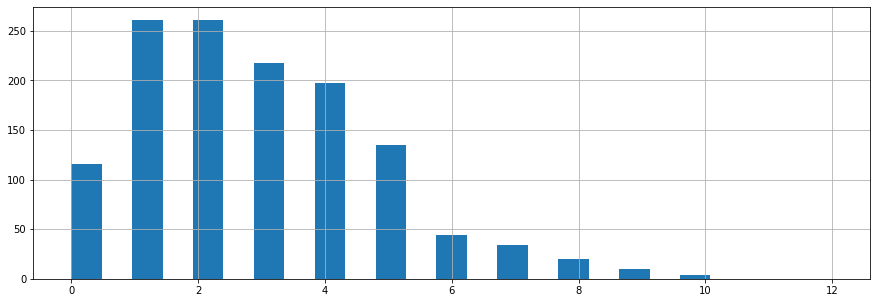

In [40]:
#построение гистаграммы по столбцу неоплаченные_продукты_штук_квартал
market_file['неоплаченные_продукты_штук_квартал'].hist(bins=25, range = (0, 12), figsize=(15, 5))

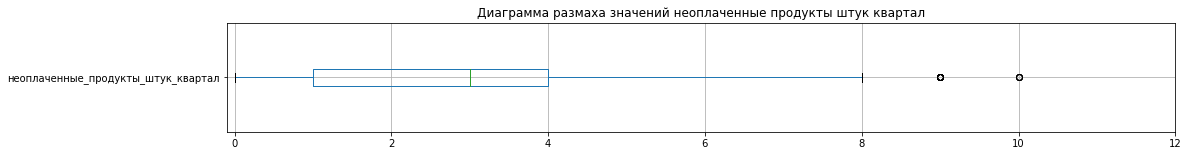

In [41]:
# построение диаграммы размаха по столбцу неоплаченные_продукты_штук_квартал
fig, ax = plt.subplots(figsize = (17,2))
ax = market_file[['неоплаченные_продукты_штук_квартал']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений неоплаченные продукты штук квартал')
ax.set_xlim(-0.1, 12);

In [42]:
# вывод числового описания данных 
market_file['неоплаченные_продукты_штук_квартал'].describe()

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

По данным графиков можно сказать, что значения столбца неоплаченные_продукты_штук_квартал имеют выбросы, среднее значение и медиана близки по значению. По гистограмме видно, что столбец неоплаченные_продукты_штук_квартал не имеет нормального распределения. Также можно заметить, что в столбце неоплаченные_продукты_штук_квартал есть значения 0, следовательно покупатель либо оплачивал все товары, либо не совершал покупки в принципе.

<AxesSubplot:>

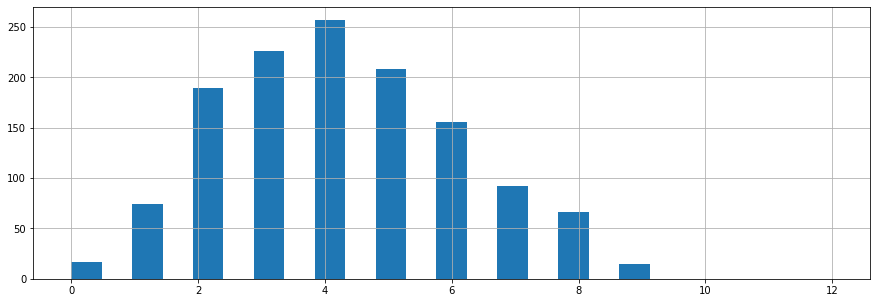

In [43]:
#построение гистаграммы по столбцу ошибка_сервиса
market_file['ошибка_сервиса'].hist(bins=25, range = (0, 12), figsize=(15, 5))

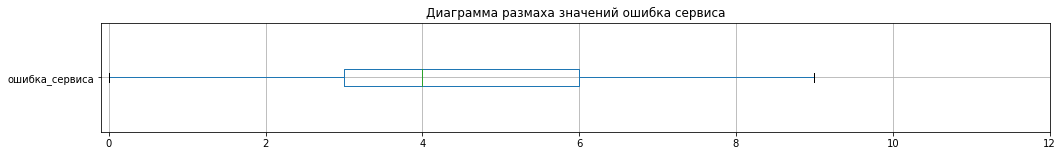

In [44]:
# построение диаграммы размаха по столбцу ошибка_сервиса
fig, ax = plt.subplots(figsize = (17,2))
ax = market_file[['ошибка_сервиса']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений ошибка сервиса')
ax.set_xlim(-0.1, 12);

In [45]:
# вывод числового описания данных 
market_file['ошибка_сервиса'].describe()

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

По данным графиков можно сказать, что значения столбца ошибка_сервиса не имеют выбросы, среднее значение и медиана близки по значению. По гистограмме видно, что столбец ошибка_сервиса имеет нормальное распределение.

<AxesSubplot:>

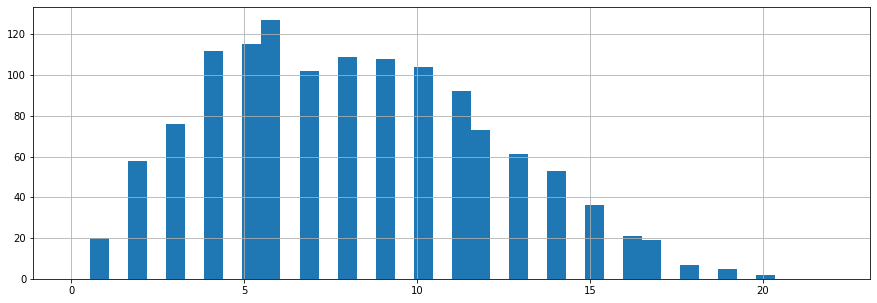

In [46]:
#построение гистаграммы по столбцу страниц_за_визит
market_file['страниц_за_визит'].hist(bins=40, range = (0, 22), figsize=(15, 5))

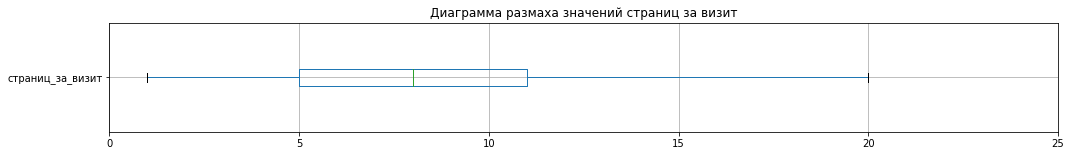

In [47]:
# построение диаграммы размаха по столбцу ошибка_сервиса
fig, ax = plt.subplots(figsize = (17,2))
ax = market_file[['страниц_за_визит']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений страниц за визит')
ax.set_xlim(0, 25);

In [48]:
# вывод числового описания данных 
market_file['страниц_за_визит'].describe()

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

По данным графиков можно сказать, что значения столбца страниц_за_визит не имеют выбросы, среднее значение и медиана близки по значению. По гистограмме видно, что столбец страниц_за_визит не имеет нормальное распределение.

<AxesSubplot:>

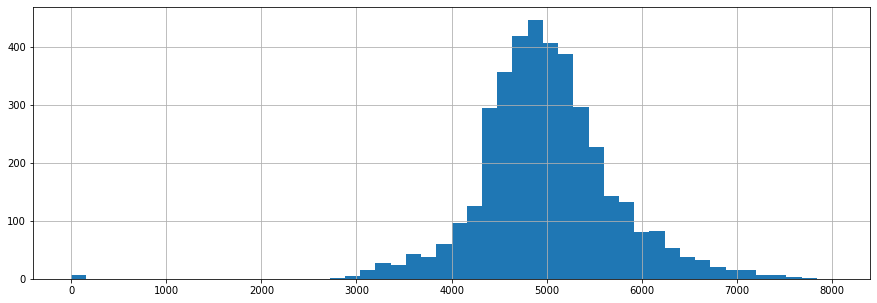

In [49]:
#построение гистаграммы по столбцу выручка
market_money['выручка'].hist(bins=50, range = (0, 8000), figsize=(15, 5))

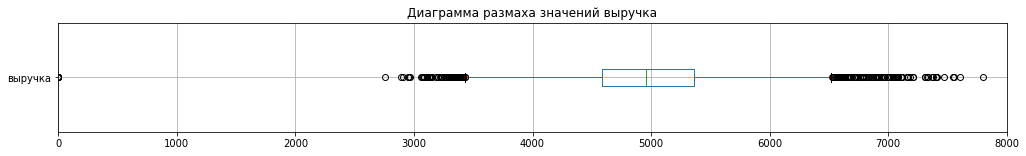

In [50]:
# построение диаграммы размаха по столбцу выручка
fig, ax = plt.subplots(figsize = (17,2))
ax = market_money[['выручка']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений выручка')
ax.set_xlim(0, 8000);

In [51]:
# вывод числового описания данных 
market_money['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

In [52]:
# удаление выбросов
market_money = market_money[market_money['выручка'] < 10000]

По данным графиков можно сказать, что значения столбца выручка имеют большое количество выбросов, особенно примечателен выброс в районе нуля. По гистограмме видно, что столбец выручка имеет нормальное распределение.

<AxesSubplot:>

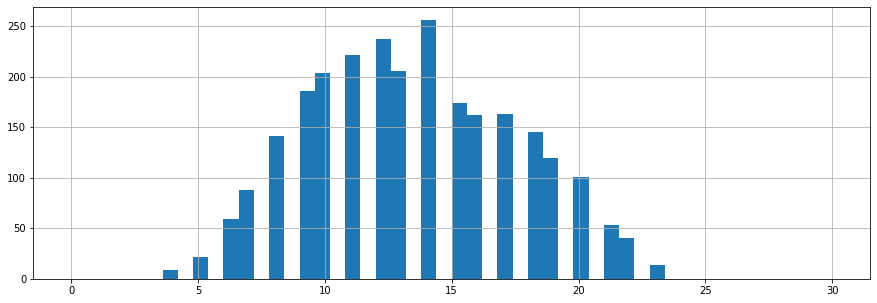

In [53]:
#построение гистаграммы по столбцу минут
market_time['минут'].hist(bins=50, range = (0, 30), figsize=(15, 5))

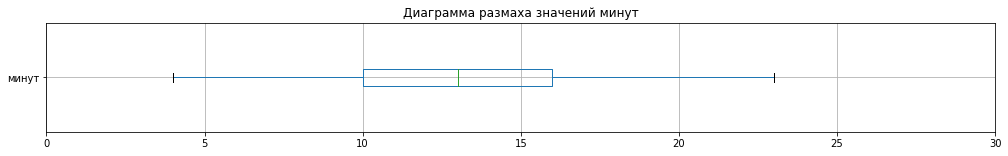

In [54]:
# построение диаграммы размаха по столбцу минут
fig, ax = plt.subplots(figsize = (17,2))
ax = market_time[['минут']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений минут')
ax.set_xlim(0, 30);

In [55]:
# вывод числового описания данных 
market_time['минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

По данным графиков можно сказать, что значения столбца минут не имеют выбросов, среднее значение и медиана близки по значению. По гистограмме видно, что столбец минут имеет нормальное распределение.

<AxesSubplot:>

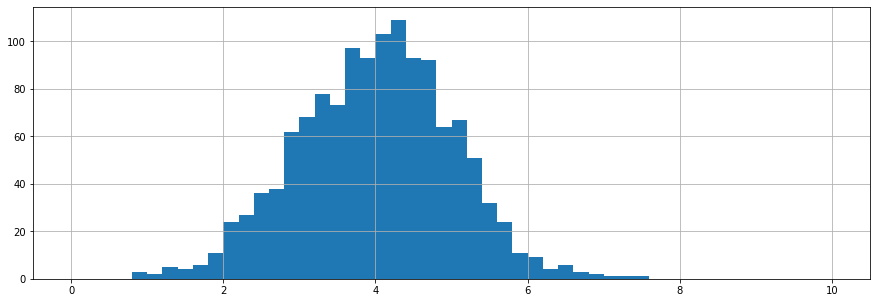

In [56]:
#построение гистаграммы по столбцу прибыль
money['прибыль'].hist(bins=50, range = (0, 10), figsize=(15, 5))

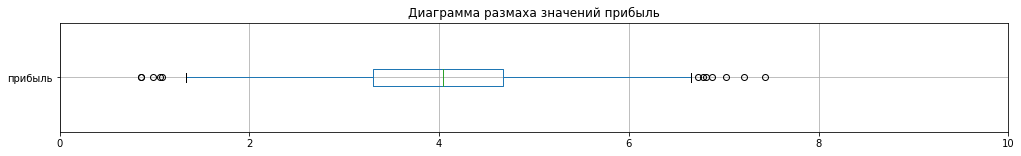

In [57]:
# построение диаграммы размаха по столбцу прибыль
fig, ax = plt.subplots(figsize = (17,2))
ax = money[['прибыль']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений прибыль')
ax.set_xlim(0, 10);

In [58]:
# вывод числового описания данных 
money['прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

По данным графиков можно сказать, что значения столбца прибыль имеют выбросы, среднее значение и медиана близки по значению. По гистограмме видно, что столбец прибыль имеет нормальное распределение.

In [59]:
# подсчет суммарной выручки для каждого id
market_money.groupby('id')['выручка'].sum().sort_values()

id
215348     3293.1
215359     4735.0
215357     5986.3
215564    10437.6
215716    10575.9
           ...   
215558    18838.8
216144    18976.3
215493    19385.9
215435    19482.8
215841    19766.5
Name: выручка, Length: 1300, dtype: float64

В результате сортировки видно, что все покупатели делали покупки в течение последних 3 месяцев.

**Вывод по результатам исследовательского анализа данных:**\
В результате выполнения исследовательского анализа данных можно сказать, что большая часть покупателей, отраженных в категориальных признаках датафрейма market_file, имеют прежний уровень покупательской активности, стандартный тип сервиса, а также получают дополнительные предложения о товарах.\
Большая часть количественных признаков датафрейма market_file не имеет нормального распределения, но имеет выбросы.
Графики, построенные по столбцам датафреймов market_money, market_time, money, исеют нормальное распределение, но стоит отметить, что по диаграмме размаха датайрема market_money имеет большое количество выбросов с двх сторон. 

## Объединение таблиц

In [60]:
#объединение таблиц market_money и market_time по столбцам id и период
market_money_time = pd.merge(market_money, market_time, on=['id', 'период'], how = 'outer')
market_money_time

,id,период,выручка,минут
0,215348,препредыдущий_месяц,0.0,NaN
1,215348,текущий_месяц,3293.1,14.0
2,215348,предыдущий_месяц,0.0,13.0
3,215349,препредыдущий_месяц,4472.0,NaN
4,215349,текущий_месяц,4971.6,10.0
...,...,...,...,...
3895,216646,предыдущий_месяц,4923.0,18.0
3896,216647,предыдущий_месяц,4720.0,15.0
3897,216647,препредыдущий_месяц,5183.0,NaN
3898,216647,текущий_месяц,4448.3,10.0


In [61]:
# создание таблицы с выручкой и временем по месяцам
market_money_time = pd.pivot(market_money_time, index='id', columns='период', values=['выручка','минут'])
market_money_time

выручка                                              минут  \
период предыдущий_месяц препредыдущий_месяц текущий_месяц предыдущий_месяц   
id                                                                           
215348              0.0                 0.0        3293.1             13.0   
215349           5216.0              4472.0        4971.6             12.0   
215350           5457.5              4826.0        5058.4              8.0   
215351           6158.0              4793.0        6610.4             11.0   
215352           5807.5              4594.0        5872.5              8.0   
...                 ...                 ...           ...              ...   
216643           3664.0              4704.0        4741.7             14.0   
216644           4729.0              5299.0        5353.0             12.0   
216645           5160.0              5334.0        5139.2             12.0   
216646           4923.0              4725.0        5224.6             18.0   
216647           4720.0              5183.0        4448.3             15.0   

                                          
период препредыдущий_месяц текущий_месяц  
id                                        
215348                 NaN          14.0  
215349                 NaN          10.0  
215350                 NaN          13.0  
215351                 NaN          13.0  
215352                 NaN          11.0  
...                    ...           ...  
216643                 NaN           7.0  
216644                 NaN          11.0  
216645                 NaN          18.0  
216646                 NaN           7.0  
216647                 NaN          10.0  

[1300 rows x 6 columns]

In [62]:
# переименование столбцов
market_money_time.columns=['выручка_пред_месяц',
                           'выручка_пре_пред_месяц',
                           'выручка_тек_месяц',
                           'мин_тек_месяц',
                           'мин_пре_пред_месяц',
                           'мин_пред_месяц',
                          ]
market_money_time.head()

,выручка_пред_месяц,выручка_пре_пред_месяц,выручка_тек_месяц,мин_тек_месяц,мин_пре_пред_месяц,мин_пред_месяц
id,,,,,,
215348,0.0,0.0,3293.1,13.0,NaN,14.0
215349,5216.0,4472.0,4971.6,12.0,NaN,10.0
215350,5457.5,4826.0,5058.4,8.0,NaN,13.0
215351,6158.0,4793.0,6610.4,11.0,NaN,13.0
215352,5807.5,4594.0,5872.5,8.0,NaN,11.0


In [63]:
market_money_time.reset_index(inplace=True)

In [64]:
# заполнение столбца мин_пре_пред_месяц средним значением столбцов мин_тек_месяц и мин_пред_месяц
market_money_time['мин_пре_пред_месяц']=(market_money_time['мин_тек_месяц']+market_money_time['мин_пред_месяц'])/2

In [65]:
#объединение таблиц market_file и market_money_time по столбцy id
market_fmt = pd.merge(market_file, market_money_time, on='id', how = 'outer')
market_fmt.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_месяц,выручка_пре_пред_месяц,выручка_тек_месяц,мин_тек_месяц,мин_пре_пред_месяц,мин_пред_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13.0,13.5,14.0
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,11.0,10.0
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,10.5,13.0
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,12.0,13.0
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,9.5,11.0


In [66]:
market_fmt = market_fmt[(market_fmt['выручка_пред_месяц'] !=0) & 
                  (market_fmt['выручка_пре_пред_месяц'] !=0) & 
                  (market_fmt['выручка_тек_месяц'] !=0)]
market_fmt

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_месяц,выручка_пре_пред_месяц,выручка_тек_месяц,мин_тек_месяц,мин_пре_пред_месяц,мин_пред_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,11.0,10.0
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,10.5,13.0
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,12.0,13.0
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,9.5,11.0
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14.0,10.5,7.0
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12.0,11.5,11.0
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12.0,15.0,18.0
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18.0,12.5,7.0


**Вывод по результатам объединения таблиц:**\
По итогам объединения таблиц были объединены три датафрейма market_file, market_money, market_time в единую таблицу, состоящую из 19 столбцов и включающую новые признаки, такие как выручка и время (в минутах) по каждому из трех месяцев.\
Также были убраны клиенты, не проявляющие активность хотя бы в одном из 3 месяцев, являвшимися выбросами, полученными при исследовательском анализе данных. Это связано с тем, что покупатели, не совершавшие покупки в одном из месяцев, могут являться новыми пользователями онлайн-магазина, поэтому их присутствие в датафрейме может исказить дальшейшие результаты. 

## Корреляционный анализ

In [67]:
# опредление коэффициентов с помощью phik_matrix()
market_fmt[['покупательская_активность', 
            'тип_сервиса',
            'разрешить_сообщать',
            'маркет_актив_6_мес',
            'маркет_актив_тек_мес',
            'длительность',
            'акционные_покупки',
            'популярная_категория',
            'средний_просмотр_категорий_за_визит',
            'неоплаченные_продукты_штук_квартал',
            'ошибка_сервиса',
            'страниц_за_визит',
            'выручка_пред_месяц',
            'выручка_пре_пред_месяц',
            'выручка_тек_месяц',
            'мин_тек_месяц',
            'мин_пре_пред_месяц',
            'мин_пред_месяц']
].phik_matrix()

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_пред_месяц', 'выручка_пре_пред_месяц', 'выручка_тек_месяц', 'мин_тек_месяц', 'мин_пре_пред_месяц', 'мин_пред_месяц']


,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_месяц,выручка_пре_пред_месяц,выручка_тек_месяц,мин_тек_месяц,мин_пре_пред_месяц,мин_пред_месяц
покупательская_активность,1.000000,0.132247,0.000000,0.546370,0.000000,0.101767,0.506991,0.298036,0.539221,0.504845,0.223697,0.748769,0.227280,0.495174,0.197213,0.685078,0.768686,0.575662
тип_сервиса,0.132247,1.000000,0.286278,0.094182,0.044796,0.401158,0.033339,0.066285,0.186635,0.120842,0.076182,0.100832,0.000000,0.068507,0.124216,0.131084,0.142782,0.000000
разрешить_сообщать,0.000000,0.286278,1.000000,0.000000,0.051971,0.253956,0.017252,0.071769,0.069322,0.195442,0.020464,0.041128,0.079830,0.000000,0.060907,0.042350,0.000000,0.000000
маркет_актив_6_мес,0.546370,0.094182,0.000000,1.000000,0.080454,0.000000,0.278729,0.149812,0.205783,0.286304,0.147270,0.394108,0.149129,0.312243,0.039795,0.363780,0.413320,0.328385
маркет_актив_тек_мес,0.000000,0.044796,0.051971,0.080454,1.000000,0.174385,0.000000,0.136175,0.246726,0.143827,0.116310,0.000000,0.054683,0.000000,0.000000,0.106879,0.126833,0.062485
длительность,0.101767,0.401158,0.253956,0.000000,0.174385,1.000000,0.000000,0.000000,0.187774,0.191923,0.174467,0.122727,0.125303,0.114058,0.147048,0.024075,0.050297,0.100502
акционные_покупки,0.506991,0.033339,0.017252,0.278729,0.000000,0.000000,1.000000,0.122840,0.199417,0.237583,0.000000,0.310741,0.065412,0.225681,0.071094,0.262189,0.306141,0.250014
популярная_категория,0.298036,0.066285,0.071769,0.149812,0.136175,0.000000,0.122840,1.000000,0.225622,0.248558,0.000000,0.160623,0.250974,0.045814,0.237240,0.195219,0.165722,0.089923
средний_просмотр_категорий_за_визит,0.539221,0.186635,0.069322,0.205783,0.246726,0.187774,0.199417,0.225622,1.000000,0.325688,0.069908,0.262610,0.100332,0.176770,0.092597,0.159393,0.204940,0.182708
неоплаченные_продукты_штук_квартал,0.504845,0.120842,0.195442,0.286304,0.143827,0.191923,0.237583,0.248558,0.325688,1.000000,0.033392,0.363879,0.249471,0.261530,0.230022,0.255982,0.344467,0.232121


**Вывод по корреляционному анализу:**\
По данным расчета коэффициентов корелляции можно сказать, что высокая прямая связь между целевым признаком "покупательская_активность" и входными признаками "страниц_за_визит" и "мин_пре_пред_месяц". Заметная прямая связь между целевым признаком "покупательская_активность" и входными признаками "маркет_актив_6_мес", "средний_просмотр_категорий_за_визит", "неоплаченные_продукты_штук_квартал", "мин_тек_месяц", "мин_пред_месяц". Не наблюдается связи между целевым признаком "покупательская_активность" и входными признаками "разрешить_сообщать", "маркет_актив_тек_мес", "выручка_тек_месяц". Мультиколлинеарности между входными признаками не наблюдается.

## Использование пайплайнов

In [68]:
market_fmt

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_месяц,выручка_пре_пред_месяц,выручка_тек_месяц,мин_тек_месяц,мин_пре_пред_месяц,мин_пред_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,11.0,10.0
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,10.5,13.0
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,12.0,13.0
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,9.5,11.0
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14.0,10.5,7.0
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12.0,11.5,11.0
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12.0,15.0,18.0
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18.0,12.5,7.0


In [69]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [70]:
label_encoder = LabelEncoder()
label_encoder.fit(market_fmt['покупательская_активность'])
market_fmt['покупательская_активность']=label_encoder.transform(market_fmt['покупательская_активность'])

In [71]:
market_fmt

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_месяц,выручка_пре_пред_месяц,выручка_тек_месяц,мин_тек_месяц,мин_пре_пред_месяц,мин_пред_месяц
1,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,11.0,10.0
2,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,10.5,13.0
3,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,12.0,13.0
4,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,9.5,11.0
5,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,0,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14.0,10.5,7.0
1296,216644,0,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12.0,11.5,11.0
1297,216645,0,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12.0,15.0,18.0
1298,216646,0,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18.0,12.5,7.0


In [72]:
# деление датафрейма market_fmt на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    market_fmt.drop(columns=['id', 'покупательская_активность']),
    market_fmt['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_fmt['покупательская_активность']
)

In [73]:
# создание списков с названиями категориальных признаков
ohe_columns = ['популярная_категория']

In [74]:
# создание списков с названиями категориальных признаков
ord_columns = ['тип_сервиса', 'разрешить_сообщать']

In [75]:
# создание списков с названиями количественных признаков
num_columns = ['маркет_актив_6_мес',
               'маркет_актив_тек_мес',
               'длительность',
               'акционные_покупки',
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',
               'ошибка_сервиса',
               'страниц_за_визит',
               'выручка_пред_месяц',
               'выручка_пре_пред_месяц',
               'выручка_тек_месяц',
               'мин_тек_месяц',
               'мин_пре_пред_месяц',
               'мин_пред_месяц'
              ]

In [76]:
# создание пайплайна для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output = False))
                    ]
                   )

In [77]:
# создание пайплайна для подготовки признаков из списка ord_columns
ord_pipe = Pipeline([('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ord', OrdinalEncoder(
                         categories=[
                             ['стандарт', 'премиум'],
                             ['нет', 'да']
                         ], handle_unknown='use_encoded_value', unknown_value=np.nan)
                     ),
                     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
                     )
                    ]
                   )

In [78]:
# создание общего пайплайна для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [79]:
# создание итогового пайплайна: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [80]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range (2, 5),
        'models__max_features': range (2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range (2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range (1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
        )],
        'models__kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

В качестве метрики была выбрана ROC-AUC, так как значений "Прежний уровень" в столбце "покупательская активность" примерно в 2 раза больше, чем значений  "Снизилась".

In [81]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/_response.py", line 211, in _get_response_values
    y_pred = prediction_method(X)
  

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
        

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/_response.py", line 211, in _get_response_values
    y_pred = prediction_method(X)
  

In [82]:
y_pred = randomized_search.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.8352792489167068

**Вывод по использованию пайплайнов:**\
В результате использования пайплайнов категориальные признаки были закодированы при помощи кодировщиков OneHotEncoder и OrdinalEncoder, а количественные масштабированы скейлером StandardScaler. Также были обучены 4 модели: DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, SVC с различными гиперпараметрами. В качестве метрики была выбрана ROC-AUC, показавшая значение лучшей модели - DecisionTreeClassifier с гиперпараметрами max_depth=2, max_features=4 - 0.816.

## Анализ важности признаков

In [83]:
best_model = randomized_search.best_estimator_

In [84]:
explainer = shap.SamplingExplainer(best_model.named_steps['models'].predict,
                                   best_model.named_steps['preprocessor'].transform(X_train))

In [85]:
shap_values = explainer.shap_values(best_model.named_steps['preprocessor'].transform(X_test))

  0%|          | 0/325 [00:00<?, ?it/s]

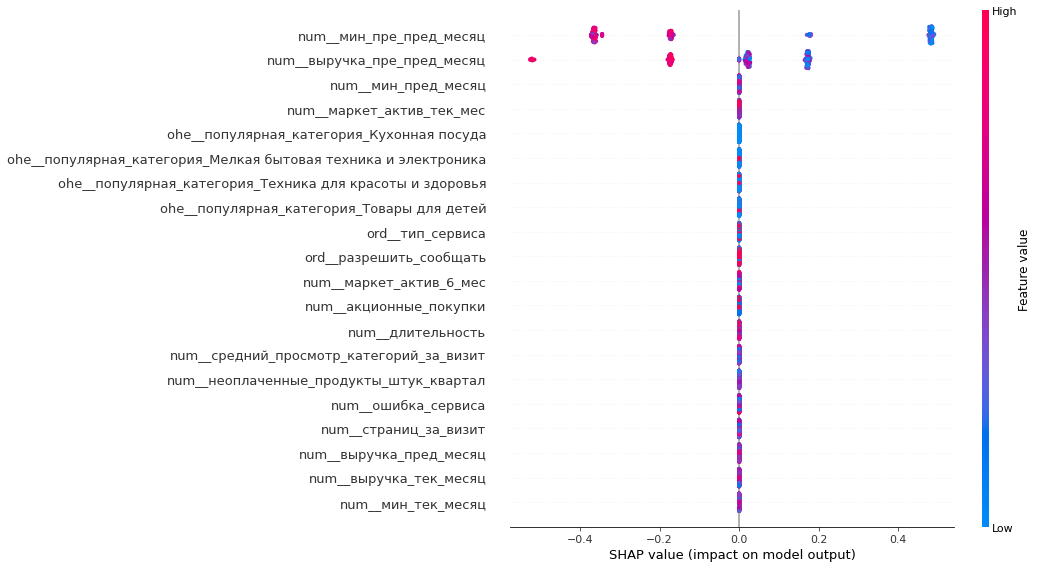

In [86]:
shap.summary_plot(shap_values, 
                  best_model.named_steps['preprocessor'].transform(X_test), 
                  feature_names=best_model.named_steps['preprocessor'].get_feature_names_out(), 
                  plot_size=(15,8)
                 )

**Вывод по результатам анализа важности признаков:**\
По данным диаграммы shap.plots.beeswarm можно сказать, что чем выше значения признаков "мин пре пред месяц", "выручка пре  пред месяц" тем ниже вероятность прогноза целевого признака "покупательская активность". Перечисленные выше входные признаки больше всего влияют на целевой признак.

## Сегментация покупателей

In [87]:
# добавление столбца с веротяностями предсказаний 
X_test['вероятности']=best_model.predict_proba(X_test)[:,1]

In [88]:
# добавление столбца с суммарной выручкой
X_test['суммарная_выручка']=X_test['выручка_пре_пред_месяц']+X_test['выручка_пред_месяц']+X_test['выручка_тек_месяц']
X_test

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_месяц,выручка_пре_пред_месяц,выручка_тек_месяц,мин_тек_месяц,мин_пре_пред_месяц,мин_пред_месяц,вероятности,суммарная_выручка
1098,стандарт,да,5.3,5,433,0.91,Техника для красоты и здоровья,1,1,0,7,4712.0,5160.0,5230.7,15.0,17.5,20.0,0.400000,15102.7
121,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,5403.5,4889.0,5228.0,12.0,10.0,8.0,0.794030,15520.5
953,премиум,да,3.9,5,410,0.20,Косметика и аксесуары,3,1,5,14,5052.5,5348.0,4926.4,17.0,15.0,13.0,0.133962,15326.9
365,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,4821.0,4872.0,5221.4,12.0,13.0,14.0,0.133962,14914.4
152,стандарт,да,3.5,4,573,0.40,Косметика и аксесуары,2,4,1,4,4137.0,4278.0,3808.1,11.0,11.5,12.0,0.794030,12223.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,премиум,да,4.0,5,1073,0.40,Товары для детей,4,2,3,3,2909.0,4740.0,3933.4,10.0,10.0,10.0,0.794030,11582.4
771,премиум,да,4.1,3,208,0.13,Косметика и аксесуары,5,2,1,10,5004.0,5154.0,5004.0,12.0,10.0,8.0,0.190476,15162.0
156,стандарт,да,3.4,5,458,0.90,Товары для детей,2,4,2,2,3432.0,4543.0,3412.5,11.0,10.5,10.0,0.794030,11387.5
1199,стандарт,нет,4.0,3,509,0.25,Косметика и аксесуары,2,6,3,13,4369.0,4847.0,4913.7,13.0,11.5,10.0,0.794030,14129.7


In [89]:
# фильтрация покупателей с высокой выручкой и вероятностью снижения покупательской активности более 0,7
X_test_снижение = X_test[(X_test['суммарная_выручка'] > 15000) & 
                  (X_test['вероятности'] > 0.7)
                       ]
X_test_снижение

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_месяц,выручка_пре_пред_месяц,выручка_тек_месяц,мин_тек_месяц,мин_пре_пред_месяц,мин_пред_месяц,вероятности,суммарная_выручка
121,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,5403.5,4889.0,5228.0,12.0,10.0,8.0,0.79403,15520.5
496,премиум,да,4.3,4,1041,0.99,Кухонная посуда,4,1,6,6,5339.0,4880.0,5866.8,9.0,11.5,14.0,0.79403,16085.8
404,стандарт,нет,4.0,4,475,0.30,Мелкая бытовая техника и электроника,3,3,7,7,5188.5,4635.0,5798.2,13.0,10.5,8.0,0.79403,15621.7
230,стандарт,да,2.4,4,699,0.35,Мелкая бытовая техника и электроника,2,4,5,3,5328.5,4778.0,5801.7,10.0,8.5,7.0,0.79403,15908.2
135,стандарт,да,3.9,5,855,0.99,Кухонная посуда,2,6,7,6,6349.0,4834.0,6355.5,8.0,8.0,8.0,0.79403,17538.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,5253.5,4715.0,5633.1,8.0,8.5,9.0,0.79403,15601.6
231,стандарт,нет,3.6,3,710,0.36,Товары для детей,3,5,2,1,5516.5,4393.0,6202.9,6.0,8.5,11.0,0.79403,16112.4
321,стандарт,да,4.1,3,551,0.94,Товары для детей,2,3,3,5,5213.0,4934.0,5123.3,8.0,9.5,11.0,0.79403,15270.3
1259,стандарт,да,3.3,4,575,0.23,Товары для детей,2,4,5,8,4991.0,4463.0,5578.6,11.0,11.5,12.0,0.79403,15032.6


<AxesSubplot:>

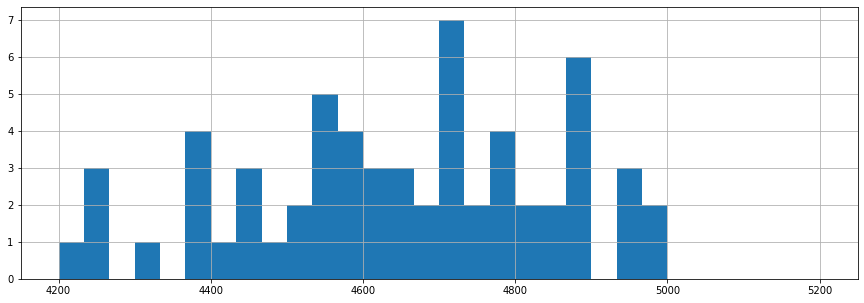

In [90]:
#построение гистoграммы
X_test_снижение['выручка_пре_пред_месяц'].hist(bins=30, range = (4200, 5200), figsize=(15, 5))

По данному графику можно сказать, что наибольшее количество клиентов приносят выручку в диапазоне от 4550 до 4900. Вероятность каждого значения равна 0,883.

<AxesSubplot:>

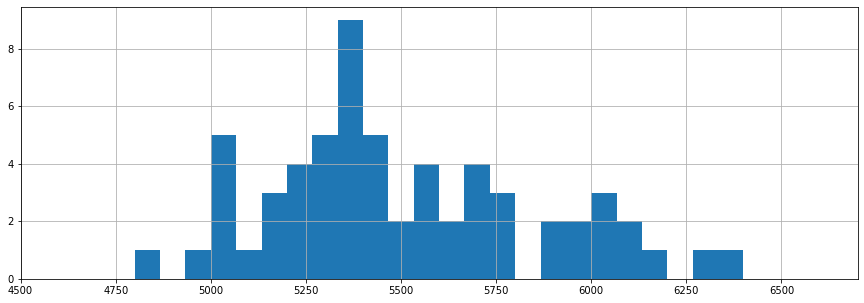

In [91]:
#построение гистаграммы
X_test_снижение['выручка_пред_месяц'].hist(bins=30, range = (4600, 6600), figsize=(15, 5))

По данному графику можно сказать, что наибольшее количество клиентов приносят выручку в диапазоне от 5250 до 5750. Вероятность каждого значения равна 0,883.

<AxesSubplot:>

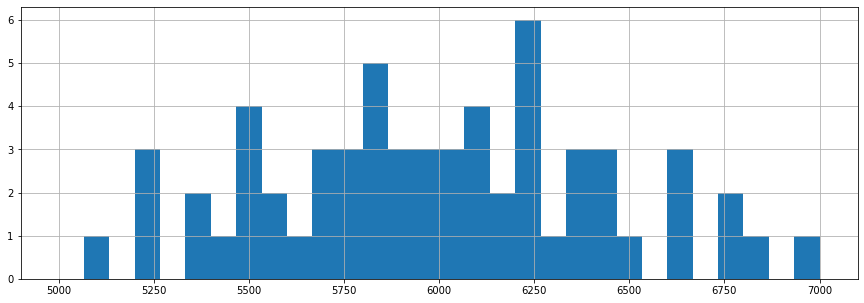

In [92]:
#построение гистаграммы
X_test_снижение['выручка_тек_месяц'].hist(bins=30, range = (5000, 7000), figsize=(15, 5))

По данному графику можно сказать, что наибольшее количество клиентов приносят выручку в диапазоне от 5700 до 6400. По сравнению с предыдущими месяцами можно сказать, что средний размер выручки растет на протяжении 3 месяцев.

<AxesSubplot:>

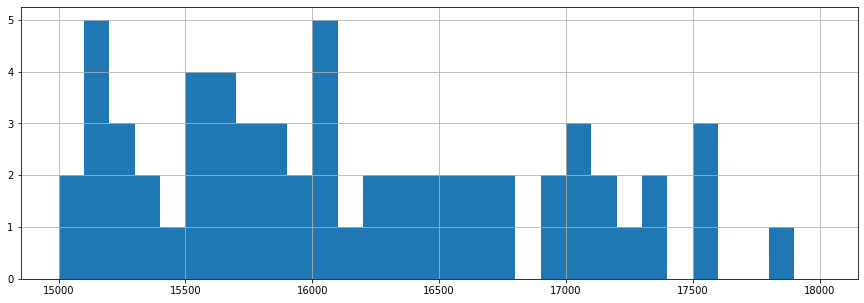

In [93]:
#построение гистаграммы
X_test_снижение['суммарная_выручка'].hist(bins=30, range = (15000, 18000), figsize=(15, 5))

По данному графику можно сказать, что наибольшее количество клиентов выделенного сегмента приносят суммарную выручку в диапазоне от 15000 до 16500. Также стоит обратить внимание, что остальная часть сегмента приносят большую суммарную выручку, чем основная часть покупателей данного сегмента.

<AxesSubplot:>

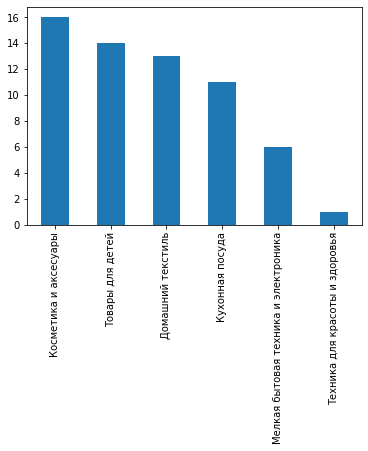

In [94]:
# построение столбчатой диаграммы
X_test_снижение['популярная_категория'].value_counts().plot(kind='bar')

У данного сегмента покупателей наиболее популярными категориями являются "домашний текстиль", "товары для детей", "косметика и аксесуары".

<AxesSubplot:>

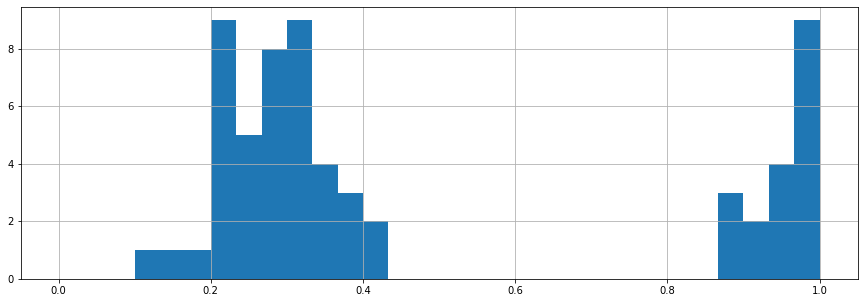

In [95]:
#построение гистаграммы
X_test_снижение['акционные_покупки'].hist(bins=30, range = (0, 1), figsize=(15, 5))

На полученном графике прослеживается четкая граница разделения. В диапазоне значений от 0,2 до 0,4 акционных покупок находятся 2/3 покупателей, остальная в диапазоне значений от 0,85 до 1.

**Вывод:**\
По полученные данным можно сделать следующие рекомендации по предотвращению снижения покупательской активности:
- уменьшение количества акций
- предлагать товары из смежных категорий (например: "косметика и аксесуары" и "техника для красоты и здоровья") 

## Общий вывод

В результате выполнения проекта были проведены предобработка данных, исследовательский анализ, объединение таблиц, корреляционных анализ, использование пайплайнов, анализ важности признаков, сегментация покупателей.\
На этапе предобработки данных столбцы датафреймов были приведены к корректному виду, а также была проведена работа с пропусками, дубликатами и неявными дубликатами для дальнейшего выполнения проекта.\
На этапе исследовательского анализа данных были построены гистограммы и диаграммы размаха, а также получены числовые описания данных для определения и учета особенностей признаков датафреймов.\
На этапе объединения таблиц датафремы были объединены и выделены новые признаки необходимые для выполнения последющих шагов проекта.\
На этапе корреляционного анализа данных были определены связи между целевым и входными признаками для отбора их в дальнейшем при обучении модели благодаря построению матрицы корреляции.\
На этапе использования пайплайна были закодированы и отмасштабированы входные признаки, обучены 4 модели: DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, SVC с различными гиперпараметрами. В качестве метрики была выбрана ROC-AUC, показавшая значение лучшей модели - DecisionTreeClassifier с гиперпараметрами max_depth=2, max_features=4 - 0.816.\
На этапе анализа важности признаков был построен график shap.plots.beeswarm, необходимый для определения важности признков и их влияния на целевой признак.\
На этапе сегментации покупателей было выделено 2 сегмента клиентов: первый - покупатели с повышенной вероятностью снижения покупательской активности и второй - покупатели с повышенной вероятностью прежнего уровня покупательской активности. Были построены графики, позволившие проанализировать данные и предложить рекомендации для предотвращения снижения покупательской активности.